In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import math
from utils import *
from mlModels import *

from sklearn.decomposition import PCA

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.feature_selection as fs
from sklearn.ensemble import RandomForestRegressor

import keras
import tensorflow as tf
from keras.models import load_model

## Load Data

In [2]:
w_length = 200
w_increment = 100

path = 'D:\Documentos\Datasets\Grabaciones 2 Corr'

raw_data, labels, angle, speed, torque = loadAndLabel(path, w_length, w_increment)

10_ext_0_31_62.txt
10_flex_0_31_62.txt
10_flex_1333_31_62.txt
10_flex_3638_31_62.txt
10_pron_0_4_62.txt
10_pron_919_4_62.txt
10_stat_0_31_62.txt
10_sup_0_4_62.txt
10_sup_919_4_62.txt
11_ext_0_29_48.txt
11_flex_0_29_48.txt
11_flex_1333_29_48.txt
11_flex_3638_29_48.txt
11_pron_0_3_48.txt
11_pron_919_3_48.txt
11_stat_0_29_48.txt
11_sup_0_3_48.txt
11_sup_919_3_48.txt
12_ext_0_31_66.txt
12_flex_0_31_66.txt
12_flex_1333_31_66.txt
12_flex_3638_31_66.txt
12_pron_0_5_66.txt
12_pron_919_5_66.txt
12_sup_0_5_66.txt
12_sup_919_5_66.txt
13_ext_0_31_70.txt
13_flex_0_31_70.txt
13_flex_1333_31_70.txt
13_flex_3638_31_70.txt
13_pron_0_5_70.txt
13_pron_919_5_70.txt
13_stat_0_5_70.txt
13_sup_0_5_70.txt
13_sup_919_5_70.txt
14_ext_0_29_4.txt
14_flex_0_29_4.txt
14_flex_1333_29_4.txt
14_flex_3638_29_4.txt
14_pron_0_4_48.txt
14_pron_919_4_48.txt
14_stat_0_4_48.txt
14_sup_919_4_48.txt
15_ext_0_29_54.txt
15_flex_0_29_54.txt
15_flex_1333_29_54.txt
15_flex_3638_29_54.txt
15_pron_0_4_54.txt
15_pron_919_4_54.txt
15_s

In [3]:
w, ch = raw_data[0].shape
print('Number of examples (m) = ', len(raw_data))
print('Window lenght (w) = ', w)
print('Number of EMG channels (ch) = ', ch)

Number of examples (m) =  22600
Window lenght (w) =  200
Number of EMG channels (ch) =  4


In [4]:
emg_raw_arr = np.array(raw_data)[:,:,0:4]
labels_arr = np.array(labels)
angle_arr = np.array(angle)
speed_arr = np.array(speed)
torque_arr = np.array(torque)
print(emg_raw_arr.shape)

(22600, 200, 4)


## EMG Features

In [5]:
f_emg_data = EMGfeatures(emg_raw_arr)

sc = MinMaxScaler()
trans = sc.fit_transform(f_emg_data)

print(f_emg_data.shape)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


(22600, 44)


## Moving Average Filter

In [6]:
maf_emg_data = maf(emg_raw_arr)

ascol = maf_emg_data.reshape(-1, ch)
sc = MinMaxScaler()
trans = sc.fit_transform(ascol)

maf_emg_data = trans.reshape(-1, w, ch)
print(maf_emg_data.shape)

maf_emg_data_flat = maf_emg_data.reshape(maf_emg_data.shape[0], w*ch)
print(maf_emg_data_flat.shape)

(22600, 200, 4)
(22600, 800)


## Autoencoder Feature Extraction

In [7]:
cnn_encoder = load_model('encoder_model.h5')
cnn_encoder.summary()

Model: "Convolutional_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 200, 4, 16)        272       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 2, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 2, 8)         520       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 1, 8)         0         
 2D)                                                             
                                                                 
Total params: 792
Trainable params: 792
Non-trainable params: 0
_________________________________________________________________


In [8]:
cnn_encoder.compile(optimizer='adam', loss='binary_crossentropy')
ae_emg = cnn_encoder.predict(emg_raw_arr)
print(ae_emg.shape)

ae_emg_data = ae_emg.reshape(ae_emg.shape[0], ae_emg.shape[1], ae_emg.shape[3])
print(ae_emg_data.shape)

ae_emg_data_flat = ae_emg.reshape(ae_emg.shape[0], -1)
print(ae_emg_data_flat.shape)

707/707 [==============================] - 10s 2ms/step
(22600, 50, 1, 8)
(22600, 50, 8)
(22600, 400)


In [9]:
_, _, Y_train_labels, Y_test_labels = train_test_split(f_emg_data, labels_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(f_emg_data, torque_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_maf, X_test_maf, Y_train_maf, Y_test_maf = train_test_split(maf_emg_data, torque_arr, stratify=labels, test_size=0.1, random_state=1)
X_train_maf_flat, X_test_maf_flat, Y_train_maf_flat, Y_test_maf_flat = train_test_split(maf_emg_data_flat, torque_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_ae, X_test_ae, Y_train_ae, Y_test_ae = train_test_split(ae_emg_data, torque_arr, stratify=labels, test_size=0.1, random_state=1)
X_train_ae_flat, X_test_ae_flat, Y_train_ae_flat, Y_test_ae_flat = train_test_split(ae_emg_data_flat, torque_arr, stratify=labels, test_size=0.1, random_state=1)

# Feature selection and extraction

## Principal Component Analysis

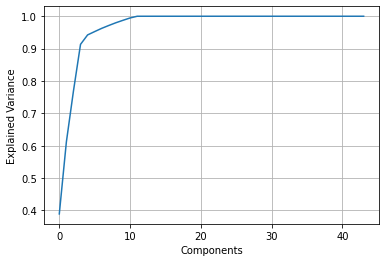

In [10]:
pca = PCA().fit(f_emg_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.grid(True)

Text(0, 0.5, 'Component 2')

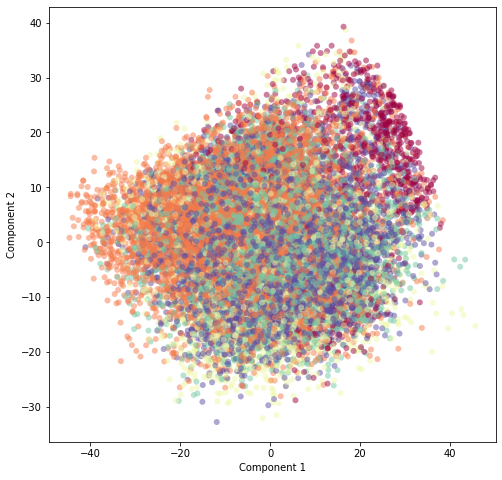

In [11]:
pca = PCA(2)
projected = pca.fit_transform(f_emg_data)
plt.figure(figsize=(8,8))
plt.scatter(projected[:,0], projected[:,1],
            c=labels_arr, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Component 1')
plt.ylabel('Component 2')

## Filter selection - Select K Best

In [ ]:
mae_list = []
for k in range(1, f_emg_data.shape[1]):

  bk = fs.SelectKBest(fs.f_classif, k=k)
  bk.fit(X_train_feat, Y_train_feat)

  X_train_trans = bk.transform(X_train_feat)
  X_test_trans = bk.transform(X_test_feat)

  rf = RandomForestRegressor()
  rf.fit(X_train_trans, Y_train_feat)

  y_pred = rf.predict(X_test_trans)
  mae = mean_absolute_error(Y_test_feat, y_pred)
  mae_list.append(mae)

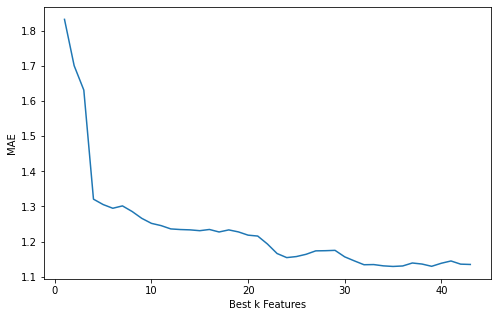

34
1.8328755621767832


In [18]:
plt.figure(figsize=(8,5))
plt.plot(range(1, f_emg_data.shape[1]), mae_list)
plt.xlabel("Best k Features")
plt.ylabel("MAE")
plt.show()
print(np.argmin(mae_list))
print(max(mae_list))

# Hyperparameter Optimization

## Random Forest

## Deep MLP